# Crime map of Monreal Island

### Data fetched form [OPEN DATA PORTAL(City of Montreal)](http://donnees.ville.montreal.qc.ca/dataset)

1. Fetch updated data from open data portal using *requests*

In [1]:
import requests
data_url = 'http://donnees.ville.montreal.qc.ca/dataset/5829b5b0-ea6f-476f-be94-bc2b8797769a/resource/c6f482bf-bf0f-4960-8b2f-9982c211addd/download/interventionscitoyendo.csv'
response = requests.get(data_url)
if response.status_code == 200:
    print('Success')
else:
    print('Check URL')

Success


2. Save fetch data as *.csv file 

In [2]:
csv_file = 'mtl_crime'
with open(csv_file, 'wb') as file:
    file.write(response.content)

3. Create dataframe from .*csv file using pandas

In [3]:
import pandas as pd
df = pd.read_csv(csv_file, encoding='latin-1', parse_dates = ['DATE'])
df.DATE = pd.to_datetime(df.DATE, format='%Y-%m-%d')
print(df.head())
print(df['DATE'].max())
print(df['DATE'].min())

                  CATEGORIE       DATE QUART   PDQ              X  \
0  Vol de véhicule à moteur 2018-09-13  jour  30.0  294904.159001   
1  Vol de véhicule à moteur 2018-04-30  jour  30.0  294904.159001   
2  Vol de véhicule à moteur 2018-09-01  nuit   7.0  290274.565000   
3                    Méfait 2017-07-21  jour  21.0       0.000000   
4                    Méfait 2017-07-29  jour  12.0       0.000000   

              Y  LONGITUDE   LATITUDE  
0  5.047549e+06 -73.626778  45.567780  
1  5.047549e+06 -73.626778  45.567780  
2  5.042150e+06 -73.685928  45.519122  
3  0.000000e+00   1.000000   1.000000  
4  0.000000e+00   1.000000   1.000000  
2019-10-25 00:00:00
2015-01-01 00:00:00


In [4]:
# Check the completeness of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152055 entries, 0 to 152054
Data columns (total 8 columns):
CATEGORIE    152055 non-null object
DATE         152055 non-null datetime64[ns]
QUART        152055 non-null object
PDQ          152051 non-null float64
X            152055 non-null float64
Y            152055 non-null float64
LONGITUDE    152055 non-null float64
LATITUDE     152055 non-null float64
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 9.3+ MB


4. Divide enties into several categories

In [5]:
# Check unique value in "CATEGORIE" column
crime_cate = df['CATEGORIE'].unique().tolist()
print(crime_cate)

['Vol de véhicule à moteur', 'Méfait', 'Vols qualifiés', 'Vol dans / sur véhicule à moteur', 'Introduction', 'Infractions entrainant la mort']


English translation:
'Vehicle theft', 'Mischief', 'Robbery', 'Theft from a motor vehicle', 'Break-in', 'Offenses causing death'

5. Covert DataFrame to GeoDataFrame

In [7]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
dfa = df.drop(['LONGITUDE', 'LATITUDE','X'], axis=1)
crs = {'init': 'epsg:3857'}
gdf = gpd.GeoDataFrame(dfa, crs=crs, geometry=geometry)
print(gdf.head())

                  CATEGORIE       DATE QUART   PDQ             Y  \
0  Vol de véhicule à moteur 2018-09-13  jour  30.0  5.047549e+06   
1  Vol de véhicule à moteur 2018-04-30  jour  30.0  5.047549e+06   
2  Vol de véhicule à moteur 2018-09-01  nuit   7.0  5.042150e+06   
3                    Méfait 2017-07-21  jour  21.0  0.000000e+00   
4                    Méfait 2017-07-29  jour  12.0  0.000000e+00   

                     geometry  
0  POINT (-73.62678 45.56778)  
1  POINT (-73.62678 45.56778)  
2  POINT (-73.68593 45.51912)  
3     POINT (1.00000 1.00000)  
4     POINT (1.00000 1.00000)  


In [8]:
# Clean the void geometry data e.g., POINT (1 1)
cleaned_gdf = gdf.loc[gdf['Y']!= 0]
cleaned_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 125270 entries, 0 to 152054
Data columns (total 6 columns):
CATEGORIE    125270 non-null object
DATE         125270 non-null datetime64[ns]
QUART        125270 non-null object
PDQ          125270 non-null float64
Y            125270 non-null float64
geometry     125270 non-null geometry
dtypes: datetime64[ns](1), float64(2), geometry(1), object(2)
memory usage: 6.7+ MB


6. Scatter plots from geopandas point geodataframes

In [9]:
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from scipy import ndimage

pylab.rcParams['figure.figsize'] = 20, 12

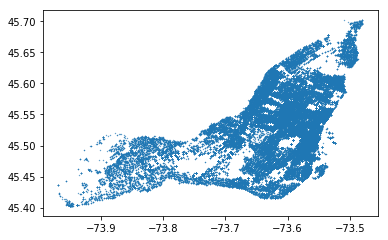

In [10]:
cleaned_gdf.plot(markersize = 0.1)

7. A matplotlib plot of crime density heatmap.

In [11]:
#define the heatmap function which takes a GeoDataFrame with point geometries. 
#Using numpy's 2D histogram binning with smoothing from scipy.
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', alpha=0.9
            , x_limit = (-73.9,-73.5), y_limit = (45.42, 45.7),c_limit = (0,1.6)
           , fname = 'heatmap'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent, alpha=alpha)
    #plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.clim(c_limit)
    plt.savefig(fname, dpi=300)

/home/xinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


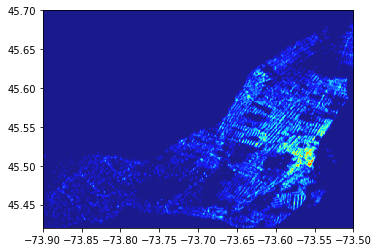

In [12]:
heatmap(cleaned_gdf, bins= (500, 1000), smoothing=1.5, fname = 'heatmap_island_test')

/home/xinda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


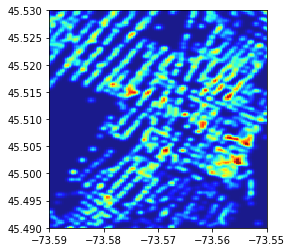

In [13]:
# Zoom in Downtown area
hm_dt = heatmap(cleaned_gdf, bins= (1500, 1500), smoothing=1.5
                , x_limit = (-73.59,-73.55), y_limit = (45.49, 45.53), c_limit = (0,0.6)
               ,fname = 'heatmap_dt_test')

10. Crime trend from 2019-07-01 00:00:00 to 2015-01-01 00:00:00

In [14]:
df['YEAR'] = df['DATE'].map(lambda x: x.year)
df['MONTH'] = df['DATE'].map(lambda x: x.month)

In [15]:
# short df for verification
df_short = df.iloc[:100]
df_short.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,YEAR,MONTH
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,2018,9
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,2018,4
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,2018,9
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,1.000000,1.000000,2017,7
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,1.000000,1.000000,2017,7


In [16]:
# extract incident number of each year of different categroies
# Function to divide df into different year
def crime_year(dataframe = df, year = 2016):
    df_year = dataframe[dataframe['YEAR'] == year]
    return df_year

In [18]:
for i in range(2015,2020):
    globals()['df_%s' % i] = crime_year(year=i)
df_2015.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,YEAR,MONTH
117,Vol dans / sur véhicule à moteur,2015-12-10,soir,46.0,299675.192008,5.050911e+06,-73.565691,45.598083,2015,12
118,Vol dans / sur véhicule à moteur,2015-12-11,jour,21.0,300642.816009,5.040606e+06,-73.553200,45.505362,2015,12
157,Introduction,2015-12-12,soir,45.0,297681.101999,5.055920e+06,-73.591324,45.643140,2015,12
158,Introduction,2015-12-13,jour,46.0,299675.192008,5.050911e+06,-73.565691,45.598083,2015,12
159,Méfait,2015-12-14,jour,27.0,293090.809001,5.046844e+06,-73.649992,45.561410,2015,12


In [19]:
# Function to get each crime number each year
def year_cate(dataframe = df_2015):
    empty_dict = {}
    for i in crime_cate:
        empty_dict[i] = len(dataframe[dataframe['CATEGORIE'] == i])
    return empty_dict

In [20]:
# crime categroies by each year
cate_2015 = year_cate(df_2015)
cate_2016 = year_cate(df_2016)
cate_2017 = year_cate(df_2017)
cate_2018 = year_cate(df_2018)
cate_2019 = year_cate(df_2019)
cate_2015

{'Vol de véhicule à moteur': 4418,
 'Méfait': 8356,
 'Vols qualifiés': 2097,
 'Vol dans / sur véhicule à moteur': 10915,
 'Introduction': 9796,
 'Infractions entrainant la mort': 27}

In [21]:
crime_dict = {}
for i in crime_cate:
    crime_dict[i] = [cate_2015[i], cate_2016[i], cate_2017[i], cate_2018[i], cate_2019[i]]

In [22]:
crime_dict

{'Vol de véhicule à moteur': [4418, 4352, 4732, 4237, 3357],
 'Méfait': [8356, 7405, 7302, 6432, 5000],
 'Vols qualifiés': [2097, 1974, 1851, 1592, 1387],
 'Vol dans / sur véhicule à moteur': [10915, 10209, 9556, 8666, 6269],
 'Introduction': [9796, 9797, 9197, 7429, 5609],
 'Infractions entrainant la mort': [27, 23, 26, 31, 13]}

In [23]:
df_crime_dict = pd.DataFrame(crime_dict)
df_renamed = df_crime_dict.rename(index = {0:2015, 1:2016, 2:2017, 3:2018, 4:2019})
df_renamed

,Vol de véhicule à moteur,Méfait,Vols qualifiés,Vol dans / sur véhicule à moteur,Introduction,Infractions entrainant la mort
2015,4418,8356,2097,10915,9796,27
2016,4352,7405,1974,10209,9797,23
2017,4732,7302,1851,9556,9197,26
2018,4237,6432,1592,8666,7429,31
2019,3357,5000,1387,6269,5609,13


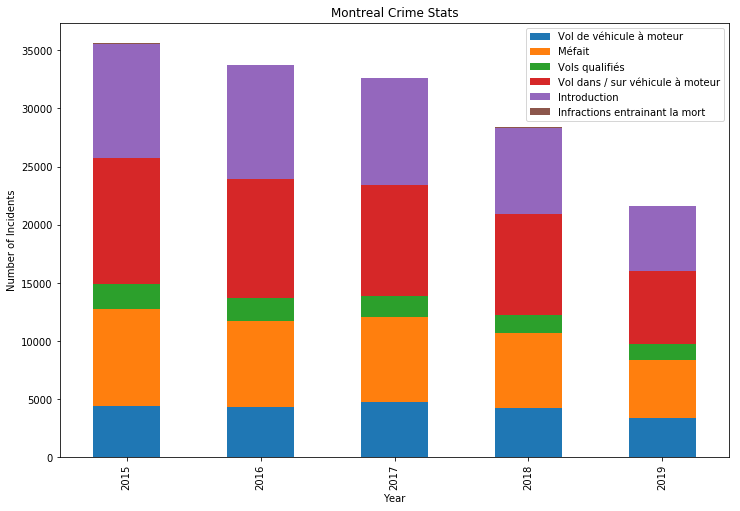

In [24]:
# Stacked bar plot
df_renamed.loc[:,['Vol de véhicule à moteur', 
                     'Méfait', 
                     'Vols qualifiés', 
                     'Vol dans / sur véhicule à moteur', 
                     'Introduction', 
                     'Infractions entrainant la mort']].plot.bar(stacked=True, figsize=(12,8), title = 'Montreal Crime Stats')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

#https://pstblog.com/2016/10/04/stacked-charts
#https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

11. Crime by month

In [25]:
# Function to get each crime number each month in one year
def month_cate(dataframe = df_2015):
    month_list = []
    for i in range(1,13):
        df_month = dataframe[dataframe['MONTH'] == i]
        for crime in crime_cate:
            crime_number = len(df_month[df_month['CATEGORIE'] == crime])
            month_list.append([i,crime,crime_number])
    df_month_crime = pd.DataFrame(month_list).pivot(index=0, columns=1, values=2)
    return df_month_crime

In [26]:
month_2015 = month_cate(dataframe = df_2015)
month_2016 = month_cate(dataframe = df_2016)
month_2017 = month_cate(dataframe = df_2017)
month_2018 = month_cate(dataframe = df_2018)
month_2019 = month_cate(dataframe = df_2019)

In [27]:
total_month = [month_2015, month_2016, month_2017, month_2018, month_2019]

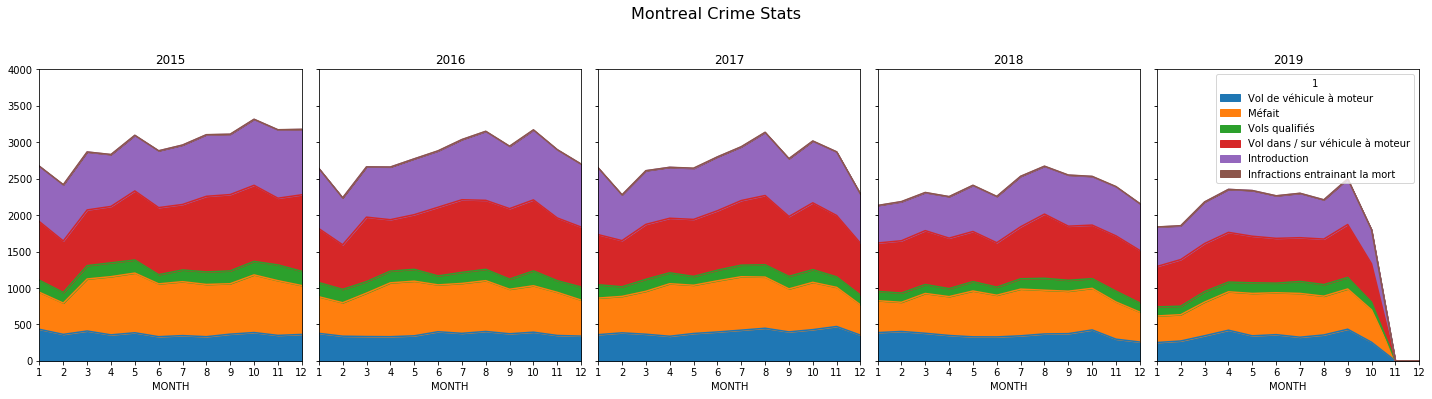

In [28]:
# make the stacked area plot based on the month
plot_year = range(0,5)
fig = plt.figure()
for year,num in zip(plot_year, range(1,6)):
    ax = fig.add_subplot(1,5,num)
    if num == 5:
        legend = True
    else:
        legend = False
    total_month[year].loc[1:,['Vol de véhicule à moteur', 
                     'Méfait', 
                     'Vols qualifiés', 
                     'Vol dans / sur véhicule à moteur', 
                     'Introduction', 
                     'Infractions entrainant la mort']].plot.area(
        stacked=True, figsize=(20, 5), title = str(2015 + year), ax=ax,legend=legend, sharey=True)
    plt.xlabel('MONTH')
    plt.xticks(np.arange(1,13,1))
    plt.ylim(0,4000)

plt.suptitle('Montreal Crime Stats', fontsize=16, y = 1.1)
plt.tight_layout(w_pad = 0)
plt.show()

11. Crime trend predicted by ARIMA

In [29]:
def cate_sum(df):
    df['sum'] = df.sum(axis = 1)

In [30]:
for i in total_month:
    cate_sum(i)

In [31]:
keys = np.array(range(2015, 2020))
for i in range(0,5):
    total_month[i]['year'] = keys[i]
    total_month[i]['month'] = total_month[i].index

In [32]:
joined = pd.concat(total_month, keys=keys)

In [100]:
df_ts = joined.droplevel(level = 0).reset_index().drop(['index'], axis = 1).drop([57, 58, 59])
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 9 columns):
Infractions entrainant la mort      57 non-null int64
Introduction                        57 non-null int64
Méfait                              57 non-null int64
Vol dans / sur véhicule à moteur    57 non-null int64
Vol de véhicule à moteur            57 non-null int64
Vols qualifiés                      57 non-null int64
sum                                 57 non-null int64
year                                57 non-null int64
month                               57 non-null int64
dtypes: int64(9)
memory usage: 4.5 KB


In [265]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

We can conclude that the time series is not stationary

In [266]:
result = adfuller(df_ts['sum'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.59432886271939
p-value: 0.9874750080530632
Critical Values:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937


The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

In [267]:
df_ts['time']= df_ts.year.apply(lambda x: str(x) + '-')+ df_ts.month.apply(lambda x: (str(x)) if len(str(x)) == 2 else ('0' + str(x)))

In [268]:
df_ts2 = df_ts[['time','sum']]

In [269]:
df_ts2.head()

1,time,sum
0,2015-01,2670
1,2015-02,2418
2,2015-03,2867
3,2015-04,2832
4,2015-05,3096


In [270]:
df_ts2.index = pd.to_datetime(df_ts2.time)

In [271]:
df_ts2.drop('time', axis =1, inplace = True)

In [272]:
df_ts2.head()

1,sum
time,
2015-01-01,2670
2015-02-01,2418
2015-03-01,2867
2015-04-01,2832
2015-05-01,3096


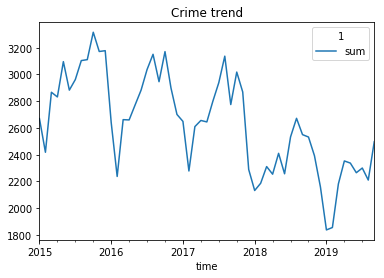

In [273]:
df_ts2.plot(title="Crime trend")

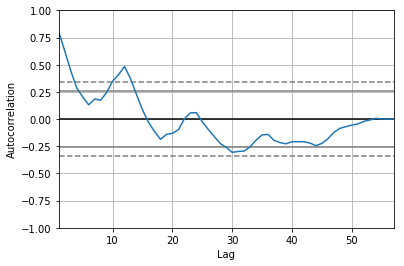

In [274]:
autocorrelation_plot(df_ts2[['sum']])

we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

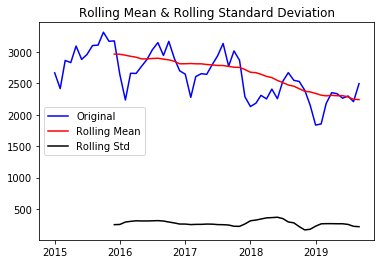

In [275]:
rolling_mean = df_ts2[['sum']].rolling(window = 12).mean()
rolling_std = df_ts2[['sum']].rolling(window = 12).std()
plt.plot(df_ts2[['sum']], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [276]:
result = seasonal_decompose(df_ts2, model='multiplicative')

In [277]:
result

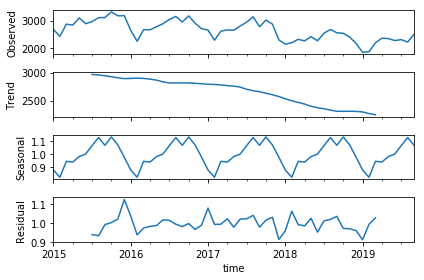

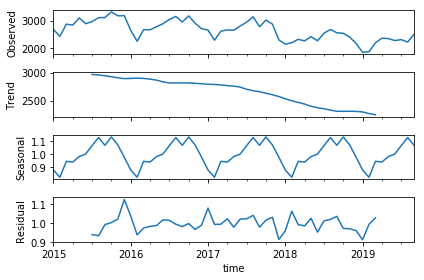

In [278]:
result.plot()

In [279]:
train = df_ts2.loc['2015-01-01':'2018-12-01']
test = df_ts2.loc['2019-01-01':]

In [291]:
model = ARIMA(train['sum'], order=(10,1,2))

/home/xinda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/xinda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [292]:
results = model.fit(disp= 0)
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.sum   No. Observations:                   47
Model:                ARIMA(10, 1, 2)   Log Likelihood                -299.959
Method:                       css-mle   S.D. of innovations            126.178
Date:                Mon, 28 Oct 2019   AIC                            627.918
Time:                        16:43:29   BIC                            653.820
Sample:                    02-01-2015   HQIC                           637.665
                         - 12-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -15.8096      4.893     -3.231      0.003     -25.399      -6.220
ar.L1.D.sum      0.1343      0.163      0.824      0.416      -0.185       0.454
ar.L2.D.sum     -1.0729      0.128     -8.35

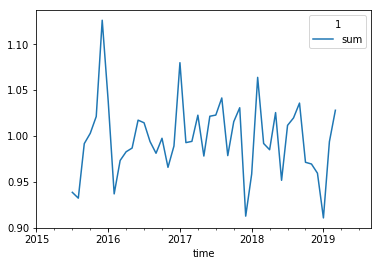

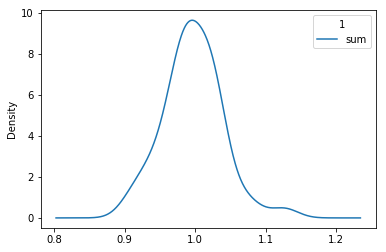

1            sum
count  45.000000
mean    0.996730
std     0.041532
min     0.910481
25%     0.973183
50%     0.993654
75%     1.021458
max     1.126234


In [293]:
# plot residual errors
residuals = pd.DataFrame(result.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

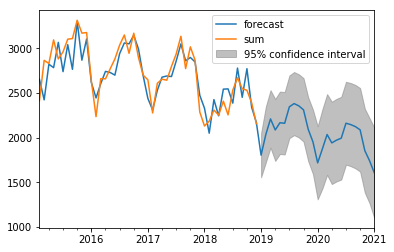

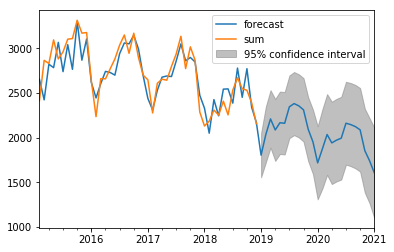

In [294]:
results.plot_predict(1,72)

# Crime rate is decreasing